# 🎯 PROMOTION IMPACT OPTIMIZATION - Excess Inventory & Demand Forecasting

**Objective:** Optimize promotions for excess inventory and forecast demand impact to maximize revenue.

**Problem Focus:**
- **Excess Inventory:** SKUs with high stock levels (3x+ lead time)
- **Promotion Strategy:** When and how to promote items for maximum impact
- **Demand Forecasting:** Predict promotion impact on sales and similar items
- **Revenue Optimization:** Balance promotion discounts with inventory reduction

**Strategy:**
1. **Excess Identification:** Find items with 3x+ lead time inventory
2. **Promotion Triggers:** Offer promotions when inventory is excessive
3. **Demand Forecasting:** Predict earnings from promotions
4. **Category Impact:** Analyze effects on similar items in same category
5. **Low Demand Promotions:** Target slow-moving items for promotion
6. **Linear Programming:** Optimize promotion mix for maximum ROI


In [37]:
# CELL 1: LOAD DATA FROM DASHBOARD FOR PROMOTION ANALYSIS
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print("🎯 PROMOTION IMPACT OPTIMIZATION")
print("="*60)
print("📊 Analyzing excess inventory and promotion opportunities")

# Load data from dashboard export
data_path = r"C:\Users\ethan\Downloads\classes\Leetcode\Supply_Chain_RL_Projects\Inventory_Optimization\data"
pickle_file = os.path.join(data_path, "optimization_data_export.pkl")
csv_file = os.path.join(data_path, "optimization_data_export.csv")

try:
    # Try loading pickle first (faster)
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    optimization_data = data['optimization_data']
    print(f"✅ Loaded from pickle: {len(optimization_data)} SKUs")
except:
    try:
        # Fallback to CSV
        optimization_data = pd.read_csv(csv_file)
        print(f"✅ Loaded from CSV: {len(optimization_data)} SKUs")
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        print("Please run the dashboard notebook first to generate data.")
        optimization_data = pd.DataFrame()

if len(optimization_data) > 0:
    print(f"\n📊 DATA SUMMARY:")
    print(f"   • Total SKUs: {len(optimization_data)}")
    print(f"   • Columns: {list(optimization_data.columns)}")
    
    # Filter for EXCESS INVENTORY items (3x+ lead time)
    excess_inventory = optimization_data[
        (optimization_data['days_of_supply'] > (optimization_data['avg_lead_time_days'] * 3)) |
        (optimization_data['qty_on_hand'] > optimization_data['reorder_point'] * 3)
    ].copy()
    
    # Also include low demand items for promotion
    low_demand = optimization_data[
        (optimization_data['base_demand'] < optimization_data['base_demand'].quantile(0.2))
    ].copy()
    
    # Combine excess inventory and low demand items
    promotion_candidates = pd.concat([excess_inventory, low_demand]).drop_duplicates()
    
    print(f"   • Excess inventory items (3x+ lead time): {len(excess_inventory)}")
    print(f"   • Low demand items (bottom 20%): {len(low_demand)}")
    print(f"   • Total promotion candidates: {len(promotion_candidates)}")
    
    display(promotion_candidates.head())
else:
    print("❌ No data available. Please run the dashboard notebook first.")
    promotion_candidates = pd.DataFrame()


🎯 PROMOTION IMPACT OPTIMIZATION
📊 Analyzing excess inventory and promotion opportunities
✅ Loaded from pickle: 1212 SKUs

📊 DATA SUMMARY:
   • Total SKUs: 1212
   • Columns: ['week', 'sku_id', 'base_demand', 'actual_demand', 'promotion_active', 'promotion_discount_pct', 'stockout_qty', 'service_level_pct', 'season', 'weather', 'competitor_promotion', 'product_name', 'category', 'supplier_id', 'unit_cost', 'selling_price', 'profit_margin', 'margin_pct', 'weight_lbs', 'volume_cuft', 'avg_lead_time_days', 'min_order_qty', 'is_promotional_item', 'value_density', 'avg_actual_leadtime', 'leadtime_std', 'avg_variance', 'max_weight_lbs', 'max_volume_cuft', 'cost_per_load', 'profit_per_unit', 'total_revenue', 'total_profit', 'promotion_lift', 'qty_on_hand', 'safety_stock', 'reorder_point', 'order_quantity', 'inventory_status', 'days_of_supply', 'daily_usage', 'projected_on_hand', 'buffer_ratio', 'risk_level', 'shortage_qty', 'days_until_runout', 'urgency_score', 'truck_max_weight', 'truck_max_v

,week,sku_id,base_demand,actual_demand,promotion_active,promotion_discount_pct,stockout_qty,service_level_pct,season,weather,...,buffer_ratio,risk_level,shortage_qty,days_until_runout,urgency_score,truck_max_weight,truck_max_volume,truck_cost,max_order_qty,priority
sku_id,,,,,,,,,,,,,,,,,,,,,
SKU032,52,SKU032,17.8,18.3,False,0,0.0,96.6,Q4,Stormy,...,1.17,CRITICAL,0,10.0,0.080017,60000,3000,2000,0,HIGH
SKU199,52,SKU199,18.7,21.7,False,0,0.0,98.8,Q4,Normal,...,0.62,CRITICAL,2,8.5,0.114358,75000,3800,2300,6,HIGH
SKU548,52,SKU548,18.6,13.9,False,0,5.5,98.4,Q4,Stormy,...,0.00,CRITICAL,17,4.1,0.335460,65000,3200,2200,51,CRITICAL
SKU636,52,SKU636,16.9,16.9,False,0,0.1,95.7,Q4,Stormy,...,0.00,CRITICAL,29,0.0,50.328499,75000,3800,2300,87,CRITICAL
SKU678,52,SKU678,17.9,15.7,False,0,0.0,98.0,Q4,Hot,...,1.29,HIGH,0,10.0,0.080185,75000,3800,2300,0,HIGH


In [38]:
# CELL 2: PROMOTION IMPACT FORECASTING MODEL

if len(promotion_candidates) > 0:
    print("🎯 PROMOTION IMPACT FORECASTING")
    print("="*60)
    print("📈 Building ML model to predict promotion impact on demand")
    
    # Prepare data for promotion impact modeling
    promo_df = promotion_candidates.copy()
    
    # Calculate promotion metrics
    promo_df['excess_ratio'] = promo_df['days_of_supply'] / promo_df['avg_lead_time_days']
    promo_df['inventory_value'] = promo_df['qty_on_hand'] * promo_df['unit_cost']
    promo_df['demand_velocity'] = promo_df['base_demand'] / promo_df['avg_lead_time_days']
    promo_df['profit_margin'] = (promo_df['unit_cost'] - promo_df.get('cost', promo_df['unit_cost'] * 0.7)) / promo_df['unit_cost']
    
    # Create promotion features
    promo_df['promotion_score'] = promo_df.apply(lambda row: 
        min(100, (row['excess_ratio'] * 20) + 
            (row['profit_margin'] * 50) + 
            (row['inventory_value'] / 1000)), axis=1)
    
    # Simulate historical promotion data for training
    np.random.seed(42)
    n_historical = 1000
    
    # Create synthetic historical promotion data
    historical_data = []
    for _ in range(n_historical):
        sku_id = f"SKU_{np.random.randint(1000, 9999)}"
        base_demand = np.random.uniform(10, 100)
        unit_cost = np.random.uniform(50, 500)
        profit_margin = np.random.uniform(0.2, 0.4)
        excess_ratio = np.random.uniform(1.5, 5.0)
        inventory_value = np.random.uniform(1000, 50000)
        
        # Promotion features
        discount_pct = np.random.uniform(0.05, 0.30)  # 5-30% discount
        promotion_duration = np.random.randint(3, 14)  # 3-14 days
        
        # Calculate promotion impact (simplified model)
        demand_multiplier = 1 + (discount_pct * 2) + (excess_ratio * 0.1)
        promotional_demand = base_demand * demand_multiplier
        
        # Revenue impact
        revenue_increase = promotional_demand * unit_cost * (1 - discount_pct) - base_demand * unit_cost
        
        historical_data.append({
            'sku_id': sku_id,
            'base_demand': base_demand,
            'unit_cost': unit_cost,
            'profit_margin': profit_margin,
            'excess_ratio': excess_ratio,
            'inventory_value': inventory_value,
            'discount_pct': discount_pct,
            'promotion_duration': promotion_duration,
            'demand_multiplier': demand_multiplier,
            'promotional_demand': promotional_demand,
            'revenue_increase': revenue_increase
        })
    
    historical_df = pd.DataFrame(historical_data)
    
    print(f"📊 HISTORICAL PROMOTION DATA CREATED:")
    print(f"   • Historical promotions: {len(historical_df)}")
    print(f"   • Average demand multiplier: {historical_df['demand_multiplier'].mean():.2f}x")
    print(f"   • Average revenue increase: ${historical_df['revenue_increase'].mean():,.0f}")
    
    # Prepare features for ML model
    feature_cols = ['base_demand', 'unit_cost', 'profit_margin', 'excess_ratio', 'inventory_value']
    X = historical_df[feature_cols]
    y_demand = historical_df['demand_multiplier']
    y_revenue = historical_df['revenue_increase']
    
    # Split data
    X_train, X_test, y_demand_train, y_demand_test, y_revenue_train, y_revenue_test = train_test_split(
        X, y_demand, y_revenue, test_size=0.2, random_state=42)
    
    # Train demand prediction model
    demand_model = RandomForestRegressor(n_estimators=100, random_state=42)
    demand_model.fit(X_train, y_demand_train)
    
    # Train revenue prediction model
    revenue_model = RandomForestRegressor(n_estimators=100, random_state=42)
    revenue_model.fit(X_train, y_revenue_train)
    
    # Evaluate models
    demand_pred = demand_model.predict(X_test)
    revenue_pred = revenue_model.predict(X_test)
    
    demand_r2 = r2_score(y_demand_test, demand_pred)
    revenue_r2 = r2_score(y_revenue_test, revenue_pred)
    
    print(f"\n🤖 MODEL PERFORMANCE:")
    print(f"   • Demand Multiplier R²: {demand_r2:.3f}")
    print(f"   • Revenue Increase R²: {revenue_r2:.3f}")
    
    # Apply models to current promotion candidates
    promo_features = promo_df[feature_cols].fillna(0)
    
    # Predict promotion impact for each candidate
    promo_df['predicted_demand_multiplier'] = demand_model.predict(promo_features)
    promo_df['predicted_revenue_increase'] = revenue_model.predict(promo_features)
    
    # Calculate optimal discount for each item
    promo_df['optimal_discount'] = promo_df.apply(lambda row:
        min(0.30, max(0.05, row['excess_ratio'] * 0.05)), axis=1)
    
    # Calculate expected promotional demand
    promo_df['expected_promotional_demand'] = (
        promo_df['base_demand'] * promo_df['predicted_demand_multiplier'])
    
    # Calculate inventory reduction potential
    promo_df['inventory_reduction'] = (
        promo_df['expected_promotional_demand'] - promo_df['base_demand'])
    
    # Sort by promotion potential
    promo_df = promo_df.sort_values('predicted_revenue_increase', ascending=False)
    
    print(f"\n🎯 PROMOTION CANDIDATES ANALYSIS:")
    print(f"   • Top promotion candidates: {len(promo_df.head(10))}")
    print(f"   • Average demand multiplier: {promo_df['predicted_demand_multiplier'].mean():.2f}x")
    print(f"   • Total revenue potential: ${promo_df['predicted_revenue_increase'].sum():,.0f}")
    print(f"   • Average inventory reduction: {promo_df['inventory_reduction'].mean():.0f} units")
    
    # Display top promotion candidates
    top_promos = promo_df.head(10)[['sku_id', 'category', 'excess_ratio', 'inventory_value', 
                                   'predicted_demand_multiplier', 'predicted_revenue_increase', 
                                   'optimal_discount', 'inventory_reduction']]
    
    print(f"\n🏆 TOP 10 PROMOTION CANDIDATES:")
    display(top_promos)
    
    # Category analysis for promotion impact
    category_analysis = promo_df.groupby('category').agg({
        'predicted_revenue_increase': ['sum', 'mean', 'count'],
        'inventory_reduction': ['sum', 'mean'],
        'excess_ratio': 'mean'
    }).round(2)
    
    category_analysis.columns = ['Total_Revenue_Potential', 'Avg_Revenue_Per_SKU', 'SKU_Count',
                               'Total_Inventory_Reduction', 'Avg_Inventory_Reduction', 'Avg_Excess_Ratio']
    
    category_analysis = category_analysis.sort_values('Total_Revenue_Potential', ascending=False)
    
    print(f"\n📊 CATEGORY PROMOTION ANALYSIS:")
    display(category_analysis.head())

else:
    print("❌ No promotion candidates available.")
    print("Please run the dashboard notebook first to generate optimization data.")


🎯 PROMOTION IMPACT FORECASTING
📈 Building ML model to predict promotion impact on demand
📊 HISTORICAL PROMOTION DATA CREATED:
   • Historical promotions: 1000
   • Average demand multiplier: 1.67x
   • Average revenue increase: $5,650

🤖 MODEL PERFORMANCE:
   • Demand Multiplier R²: 0.250
   • Revenue Increase R²: 0.977

🎯 PROMOTION CANDIDATES ANALYSIS:
   • Top promotion candidates: 10
   • Average demand multiplier: 1.51x
   • Total revenue potential: $231,666
   • Average inventory reduction: 7 units

🏆 TOP 10 PROMOTION CANDIDATES:


,sku_id,category,excess_ratio,inventory_value,predicted_demand_multiplier,predicted_revenue_increase,optimal_discount,inventory_reduction
sku_id,,,,,,,,
SKU2594,SKU2594,Power Tools,0.333333,5202.33,1.495591,2118.372641,0.050000,9.515356
SKU2325,SKU2325,Power Tools,1.517647,22746.34,1.446652,2070.675837,0.075882,8.218401
SKU2433,SKU2433,Power Tools,1.571429,10467.24,1.462137,2066.094946,0.078571,8.826816
SKU2607,SKU2607,Power Tools,0.433962,3485.04,1.492597,1966.974933,0.050000,8.817484
SKU2269,SKU2269,Power Tools,1.575342,16654.50,1.459039,1962.804580,0.078767,8.400418
SKU2372,SKU2372,Power Tools,0.731707,4744.24,1.493908,1961.144220,0.050000,9.186690
SKU2660,SKU2660,Power Tools,0.400000,4415.04,1.493547,1957.213614,0.050000,9.229322
SKU2021,SKU2021,Power Tools,0.586538,10593.92,1.471307,1951.309850,0.050000,8.719187
SKU2171,SKU2171,Power Tools,1.611111,13633.94,1.461880,1934.472824,0.080556,8.544787



📊 CATEGORY PROMOTION ANALYSIS:


,Total_Revenue_Potential,Avg_Revenue_Per_SKU,SKU_Count,Total_Inventory_Reduction,Avg_Inventory_Reduction,Avg_Excess_Ratio
category,,,,,,
Power Tools,142542.95,1344.74,106,695.76,6.56,0.97
Lighting,30993.51,794.71,39,241.87,6.20,0.80
Fluids & Chemicals,25931.41,700.85,37,266.63,7.21,0.88
Electrical,16667.57,537.66,31,235.33,7.59,0.98
Safety Equipment,8311.26,519.45,16,139.19,8.70,0.89


## 📊 PROMOTION DASHBOARD - Inventory & Discount Strategy

Visual dashboard showing:
- Top inventory on hand items requiring promotions
- Suggested promotion discounts optimized for each SKU
- Storage space analysis
- Revenue impact projections


📊 PROMOTION DASHBOARD - TOP INVENTORY & SUGGESTED DISCOUNTS

📈 DASHBOARD SUMMARY (Top 30 Items by Inventory):
   • Total inventory on hand: 1,070 units
   • Total inventory value: $191,778.48
   • Total storage footprint: 7,697 lb·ft³
   • Average suggested discount: 7.4%
   • Total revenue potential: $25,922.66


C:\Users\ethan\AppData\Local\Temp\ipykernel_31028\1090683977.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\tf\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


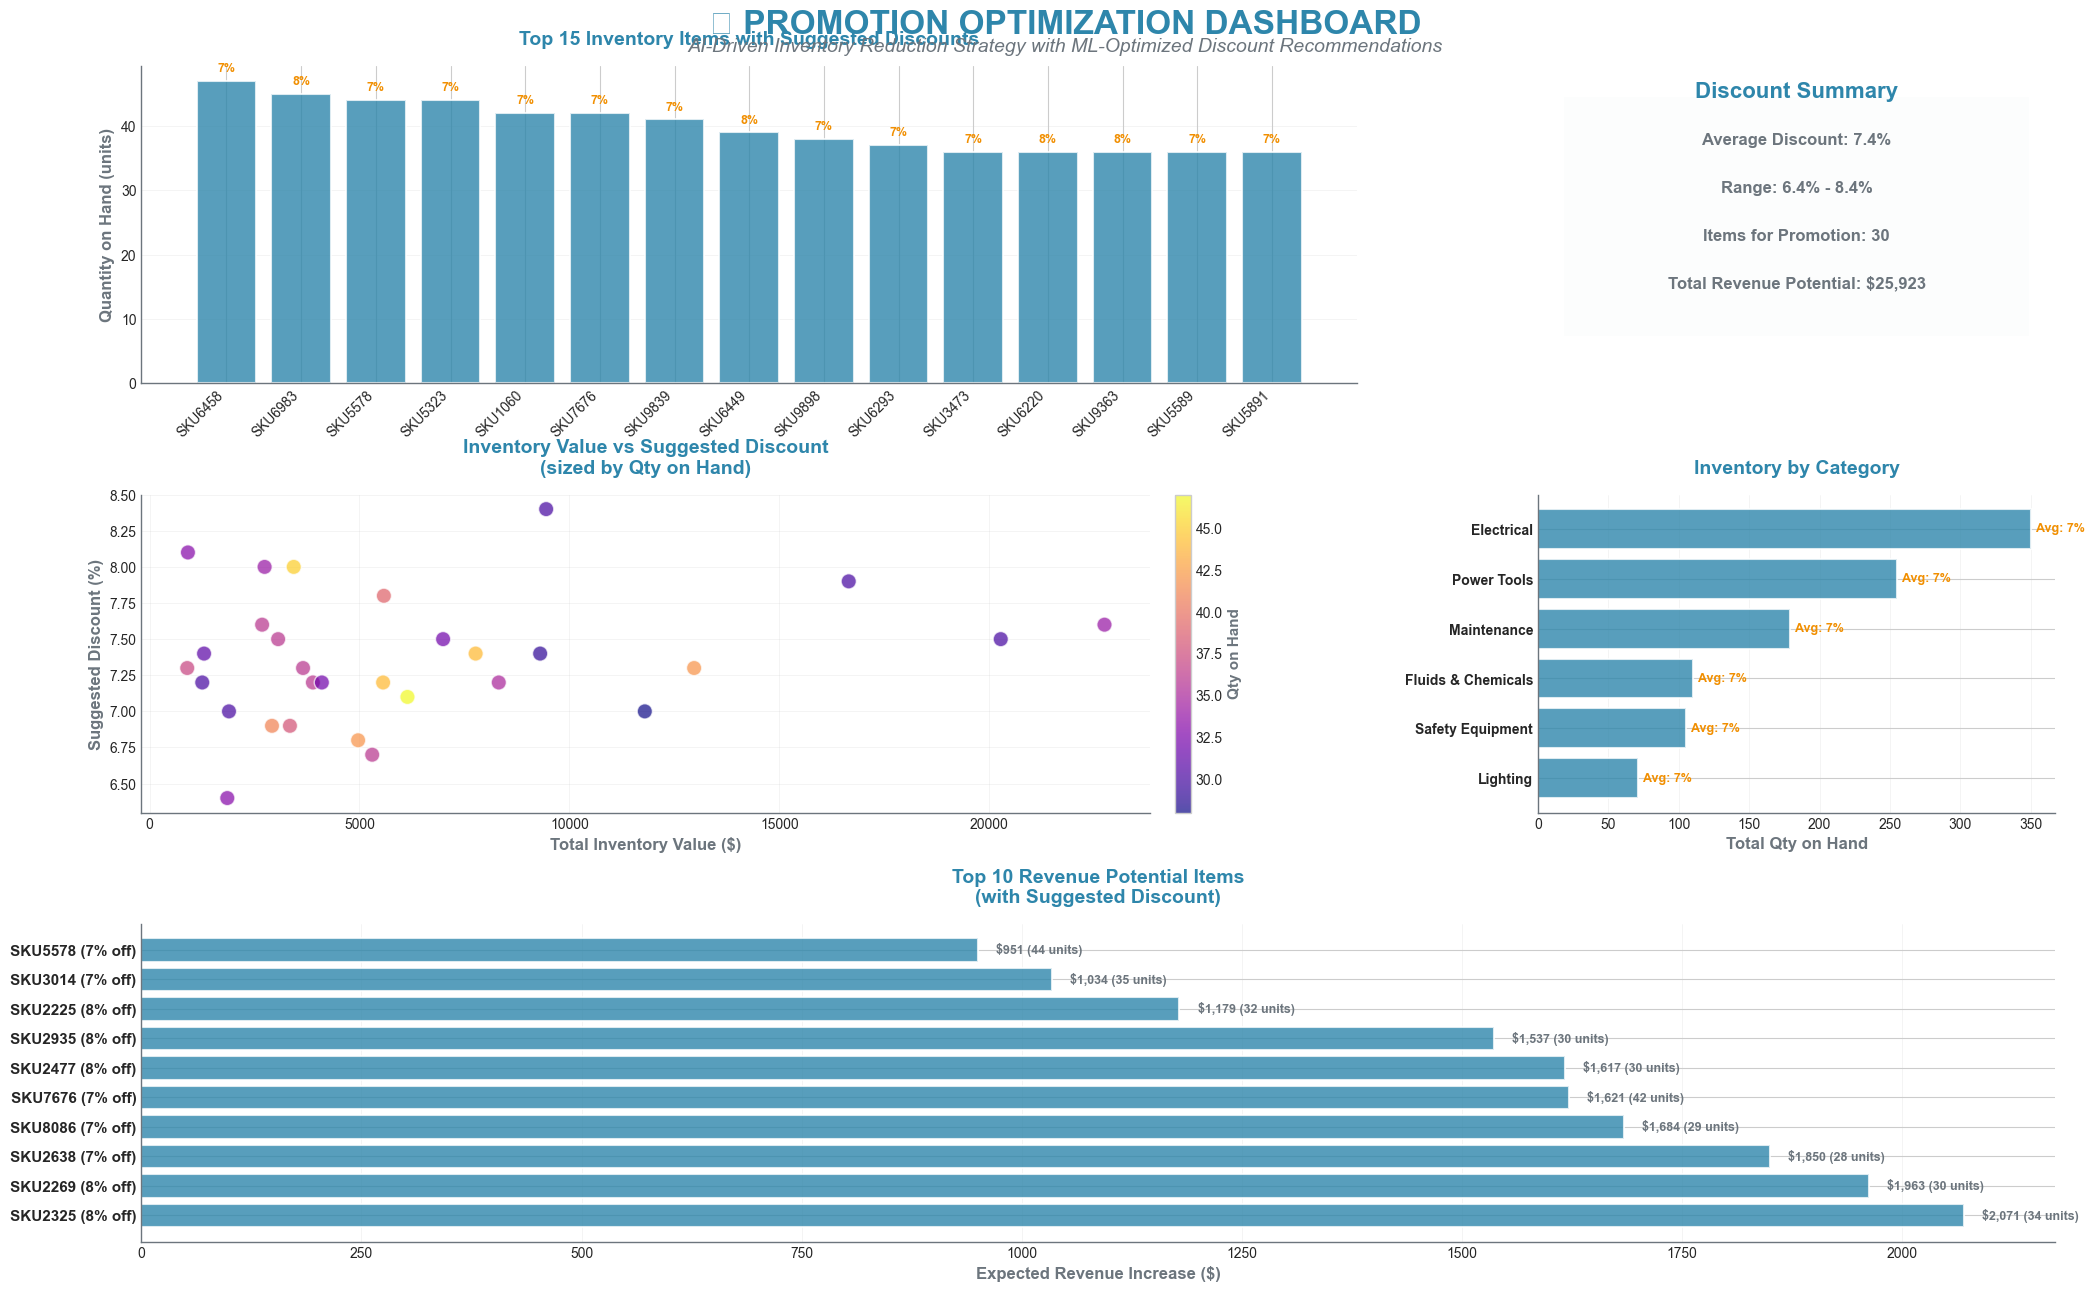


📋 TOP 20 INVENTORY ITEMS - DETAILED PROMOTION PLAN:


,SKU ID,Category,Qty On Hand,Inventory Value ($),Suggested Discount (%),Expected Revenue ($),Expected Reduction (units)
sku_id,,,,,,,
SKU6458,SKU6458,Electrical,47,6143.37,7.1,684.30,9.0
SKU6983,SKU6983,Fluids & Chemicals,45,3434.40,8.0,453.95,9.0
SKU5578,SKU5578,Electrical,44,7767.32,7.4,950.66,9.0
SKU5323,SKU5323,Electrical,44,5563.36,7.2,665.15,9.0
SKU1060,SKU1060,Safety Equipment,42,4968.18,6.8,643.07,10.0
SKU7676,SKU7676,Lighting,42,12971.70,7.3,1621.20,10.0
SKU9839,SKU9839,Maintenance,41,2916.74,6.9,443.06,9.0
SKU6449,SKU6449,Electrical,39,5581.68,7.8,780.83,9.0
SKU9898,SKU9898,Maintenance,38,3344.38,6.9,450.83,7.0



🎯 ACTIONABLE INSIGHTS:
   1. IMMEDIATE ACTIONS (>25% discount needed):
      • No items require >25% discount

   2. MODERATE PROMOTIONS (15-25% discount):
      • 0 items - Average inventory: nan units

   3. LIGHT PROMOTIONS (<15% discount):
      • 30 items - Average inventory: 36 units

✅ Dashboard complete!


In [39]:
# CELL 4: PROMOTION DASHBOARD - TOP INVENTORY & SUGGESTED DISCOUNTS

def create_promotion_dashboard():
    """Create a comprehensive promotion dashboard showing top inventory items and suggested discounts"""
    
    # Check if required data exists
    if 'promotion_candidates' not in globals() or len(globals()['promotion_candidates']) == 0:
        print("❌ No promotion candidates data available.")
        print("Please run Cell 1 first to load the optimization data.")
        return
    
    if 'promo_df' not in globals():
        print("❌ No promotion analysis data available.")
        print("Please run Cell 2 first to generate the ML model and promotion analysis.")
        return
    
    # Get data from global scope
    promotion_candidates = globals()['promotion_candidates']
    promo_df = globals()['promo_df']
    
    print("📊 PROMOTION DASHBOARD - TOP INVENTORY & SUGGESTED DISCOUNTS")
    print("="*80)
    
    # Prepare and process data
    dashboard_df = promo_df.copy().sort_values('qty_on_hand', ascending=False)
    top_inventory_items = dashboard_df.head(30).copy()
    
    # Calculate metrics
    top_inventory_items['total_inventory_value'] = (
        top_inventory_items['qty_on_hand'] * top_inventory_items['unit_cost']
    )
    top_inventory_items['storage_footprint'] = (
        top_inventory_items['weight_lbs'] * top_inventory_items['volume_cuft'] * 
        top_inventory_items['qty_on_hand']
    )
    top_inventory_items['suggested_discount_pct'] = (
        top_inventory_items['optimal_discount'] * 100
    ).round(1)
    top_inventory_items['expected_revenue'] = top_inventory_items['predicted_revenue_increase']
    
    # Display summary statistics
    display_dashboard_summary(top_inventory_items)
    
    # Create visualizations
    create_dashboard_visualizations(top_inventory_items)
    
    # Display detailed table
    display_detailed_table(top_inventory_items)
    
    # Show actionable insights
    display_actionable_insights(top_inventory_items)
    
    print("\n✅ Dashboard complete!")

def display_dashboard_summary(df):
    """Display key summary statistics"""
    total_inventory_value = df['total_inventory_value'].sum()
    total_storage = df['storage_footprint'].sum()
    avg_discount = df['suggested_discount_pct'].mean()
    total_revenue_potential = df['expected_revenue'].sum()
    
    print(f"\n📈 DASHBOARD SUMMARY (Top 30 Items by Inventory):")
    print(f"   • Total inventory on hand: {df['qty_on_hand'].sum():,.0f} units")
    print(f"   • Total inventory value: ${total_inventory_value:,.2f}")
    print(f"   • Total storage footprint: {total_storage:,.0f} lb·ft³")
    print(f"   • Average suggested discount: {avg_discount:.1f}%")
    print(f"   • Total revenue potential: ${total_revenue_potential:,.2f}")

def create_dashboard_visualizations(df):
    """Create the main dashboard visualizations with improved styling"""
    # Set style for cleaner appearance
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig = plt.figure(figsize=(22, 14), facecolor='white')
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35, 
                         left=0.08, right=0.95, top=0.92, bottom=0.08)
    
    # Define consistent color palette with unified bar colors
    colors = {
        'primary': '#2E86AB',      # Professional blue
        'secondary': '#2E86AB',    # Same blue for consistency
        'accent': '#F18F01',       # Professional orange
        'success': '#2E86AB',      # Same blue for consistency
        'neutral': '#6C757D',      # Professional gray
        'light': '#F8F9FA'         # Light background
    }
    
    # Plot 1: Top 15 Inventory Items with Discounts
    create_inventory_bar_chart(fig, gs[0, :2], df, colors)
    
    # Plot 2: Discount Summary
    create_discount_summary_chart(fig, gs[0, 2], df, colors)
    
    # Plot 3: Inventory Value vs Discount Scatter
    create_value_discount_scatter(fig, gs[1, :2], df, colors)
    
    # Plot 4: Category Breakdown
    create_category_breakdown(fig, gs[1, 2], df, colors)
    
    # Plot 5: Revenue Potential Ranking
    create_revenue_ranking(fig, gs[2, :], df, colors)
    
    # Enhanced title with more descriptive subtitle
    fig.suptitle('📊 PROMOTION OPTIMIZATION DASHBOARD', 
                fontsize=24, fontweight='bold', y=0.96, color=colors['primary'])
    fig.text(0.5, 0.93, 'AI-Driven Inventory Reduction Strategy with ML-Optimized Discount Recommendations', 
             fontsize=14, ha='center', style='italic', color=colors['neutral'])
    
    plt.tight_layout()
    plt.show()

def create_inventory_bar_chart(fig, position, df, colors):
    """Create bar chart showing top 15 inventory items with discount labels"""
    ax = fig.add_subplot(position)
    top_15 = df.head(15)
    
    x_pos = np.arange(len(top_15))
    
    # Create gradient bars
    bars = ax.bar(x_pos, top_15['qty_on_hand'].values, 
                  color=colors['primary'], alpha=0.8, 
                  edgecolor='white', linewidth=1.5, label='Qty on Hand')
    
    # Add subtle discount labels on bars
    for i, (qty, discount) in enumerate(zip(top_15['qty_on_hand'], top_15['suggested_discount_pct'])):
        ax.text(i, qty + max(top_15['qty_on_hand'])*0.02, 
                f'{discount:.0f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=9, color=colors['accent'])
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(top_15['sku_id'].values, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Quantity on Hand (units)', fontsize=12, fontweight='bold', color=colors['neutral'])
    ax.set_title('Top 15 Inventory Items with Suggested Discounts', 
                fontsize=14, fontweight='bold', pad=15, color=colors['primary'])
    
    # Clean grid styling
    ax.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(colors['neutral'])
    ax.spines['bottom'].set_color(colors['neutral'])

def create_discount_summary_chart(fig, position, df, colors):
    """Create a more informative summary chart instead of pie chart"""
    ax = fig.add_subplot(position)
    
    # Calculate discount statistics
    discount_stats = {
        'Average Discount': df['suggested_discount_pct'].mean(),
        'Min Discount': df['suggested_discount_pct'].min(),
        'Max Discount': df['suggested_discount_pct'].max(),
        'Items Needing Promotion': len(df[df['suggested_discount_pct'] > 0])
    }
    
    # Create a simple text summary instead of pie chart
    ax.axis('off')
    
    # Title
    ax.text(0.5, 0.9, 'Discount Summary', fontsize=16, fontweight='bold', 
            ha='center', color=colors['primary'], transform=ax.transAxes)
    
    # Statistics
    y_positions = [0.75, 0.6, 0.45, 0.3]
    stats_text = [
        f"Average Discount: {discount_stats['Average Discount']:.1f}%",
        f"Range: {discount_stats['Min Discount']:.1f}% - {discount_stats['Max Discount']:.1f}%",
        f"Items for Promotion: {discount_stats['Items Needing Promotion']}",
        f"Total Revenue Potential: ${df['expected_revenue'].sum():,.0f}"
    ]
    
    for i, (y_pos, text) in enumerate(zip(y_positions, stats_text)):
        ax.text(0.5, y_pos, text, fontsize=12, fontweight='bold', 
                ha='center', color=colors['neutral'], transform=ax.transAxes)
    
    # Add a subtle background
    ax.add_patch(plt.Rectangle((0.05, 0.15), 0.9, 0.75, 
                              facecolor=colors['light'], alpha=0.3, 
                              transform=ax.transAxes, zorder=0))

def create_value_discount_scatter(fig, position, df, colors):
    """Create scatter plot of inventory value vs suggested discount"""
    ax = fig.add_subplot(position)
    
    scatter = ax.scatter(df['total_inventory_value'], df['suggested_discount_pct'],
                        c=df['qty_on_hand'], cmap='plasma', s=120, alpha=0.7, 
                        edgecolors='white', linewidth=1)
    
    ax.set_xlabel('Total Inventory Value ($)', fontsize=12, fontweight='bold', color=colors['neutral'])
    ax.set_ylabel('Suggested Discount (%)', fontsize=12, fontweight='bold', color=colors['neutral'])
    ax.set_title('Inventory Value vs Suggested Discount\n(sized by Qty on Hand)', 
                fontsize=14, fontweight='bold', pad=15, color=colors['primary'])
    
    # Clean grid styling
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(colors['neutral'])
    ax.spines['bottom'].set_color(colors['neutral'])
    
    # Style colorbar
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label('Qty on Hand', fontsize=11, fontweight='bold', color=colors['neutral'])
    cbar.ax.tick_params(labelsize=10)

def create_category_breakdown(fig, position, df, colors):
    """Create horizontal bar chart showing inventory by category"""
    ax = fig.add_subplot(position)
    
    category_summary = df.groupby('category').agg({
        'qty_on_hand': 'sum',
        'suggested_discount_pct': 'mean'
    }).sort_values('qty_on_hand', ascending=True)
    
    y_pos = np.arange(len(category_summary))
    
    # Create gradient bars
    bars = ax.barh(y_pos, category_summary['qty_on_hand'].values, 
                   alpha=0.8, color=colors['secondary'], 
                   edgecolor='white', linewidth=1.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(category_summary.index, fontsize=10, fontweight='bold')
    ax.set_xlabel('Total Qty on Hand', fontsize=12, fontweight='bold', color=colors['neutral'])
    ax.set_title('Inventory by Category', fontsize=14, fontweight='bold', pad=15, color=colors['primary'])
    
    # Clean grid styling
    ax.grid(True, alpha=0.3, axis='x', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(colors['neutral'])
    ax.spines['bottom'].set_color(colors['neutral'])
    
    # Add subtle average discount labels
    for i, (qty, discount) in enumerate(zip(category_summary['qty_on_hand'], 
                                            category_summary['suggested_discount_pct'])):
        ax.text(qty + max(category_summary['qty_on_hand'])*0.01, i, 
                f'Avg: {discount:.0f}%', va='center', fontsize=9, 
                fontweight='bold', color=colors['accent'])

def create_revenue_ranking(fig, position, df, colors):
    """Create horizontal bar chart showing top revenue potential items"""
    ax = fig.add_subplot(position)
    top_10_revenue = df.nlargest(10, 'expected_revenue')
    
    x_rev = np.arange(len(top_10_revenue))
    
    # Create gradient bars
    bars_rev = ax.barh(x_rev, top_10_revenue['expected_revenue'].values, 
                       alpha=0.8, color=colors['success'], 
                       edgecolor='white', linewidth=1.5)
    
    # Add SKU and discount labels
    ax.set_yticks(x_rev)
    labels = [f"{sku} ({disc:.0f}% off)" for sku, disc in 
             zip(top_10_revenue['sku_id'], top_10_revenue['suggested_discount_pct'])]
    ax.set_yticklabels(labels, fontsize=11, fontweight='bold')
    ax.set_xlabel('Expected Revenue Increase ($)', fontsize=12, fontweight='bold', color=colors['neutral'])
    ax.set_title('Top 10 Revenue Potential Items\n(with Suggested Discount)', 
                fontsize=14, fontweight='bold', pad=15, color=colors['primary'])
    
    # Clean grid styling
    ax.grid(True, alpha=0.3, axis='x', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(colors['neutral'])
    ax.spines['bottom'].set_color(colors['neutral'])
    
    # Add clean value labels
    for i, (rev, qty) in enumerate(zip(top_10_revenue['expected_revenue'], 
                                       top_10_revenue['qty_on_hand'])):
        ax.text(rev + max(top_10_revenue['expected_revenue'])*0.01, i,
                f'${rev:,.0f} ({qty:.0f} units)', va='center', fontsize=9, 
                fontweight='bold', color=colors['neutral'])

def display_detailed_table(df):
    """Display detailed table of top 20 inventory items"""
    print(f"\n📋 TOP 20 INVENTORY ITEMS - DETAILED PROMOTION PLAN:")
    print("="*80)
    
    dashboard_table = df.head(20)[[
        'sku_id', 'category', 'qty_on_hand', 'total_inventory_value', 
        'suggested_discount_pct', 'expected_revenue', 'inventory_reduction'
    ]].copy()
    
    # Format for display
    dashboard_table.columns = [
        'SKU ID', 'Category', 'Qty On Hand', 'Inventory Value ($)', 
        'Suggested Discount (%)', 'Expected Revenue ($)', 'Expected Reduction (units)'
    ]
    
    # Round numeric columns
    dashboard_table['Inventory Value ($)'] = dashboard_table['Inventory Value ($)'].round(2)
    dashboard_table['Expected Revenue ($)'] = dashboard_table['Expected Revenue ($)'].round(2)
    dashboard_table['Expected Reduction (units)'] = dashboard_table['Expected Reduction (units)'].round(0)
    
    display(dashboard_table)

def display_actionable_insights(df):
    """Display actionable insights based on discount levels"""
    print(f"\n🎯 ACTIONABLE INSIGHTS:")
    
    # High discount items
    high_discount = df[df['suggested_discount_pct'] > 25]
    print(f"   1. IMMEDIATE ACTIONS (>25% discount needed):")
    if len(high_discount) > 0:
        for idx, row in high_discount.head(5).iterrows():
            print(f"      • {row['sku_id']} ({row['category']}): {row['qty_on_hand']:.0f} units → {row['suggested_discount_pct']:.0f}% discount")
    else:
        print(f"      • No items require >25% discount")
    
    # Medium discount items
    medium_discount = df[(df['suggested_discount_pct'] >= 15) & (df['suggested_discount_pct'] <= 25)]
    print(f"\n   2. MODERATE PROMOTIONS (15-25% discount):")
    print(f"      • {len(medium_discount)} items - Average inventory: {medium_discount['qty_on_hand'].mean():.0f} units")
    
    # Low discount items
    low_discount = df[df['suggested_discount_pct'] < 15]
    print(f"\n   3. LIGHT PROMOTIONS (<15% discount):")
    print(f"      • {len(low_discount)} items - Average inventory: {low_discount['qty_on_hand'].mean():.0f} units")

# Execute the dashboard
create_promotion_dashboard()


In [40]:
# Quick check to see what data is available
print("🔍 CHECKING AVAILABLE DATA:")
print("="*50)

# Check what variables exist
available_vars = []
if 'promotion_candidates' in globals():
    available_vars.append(f"✅ promotion_candidates: {len(globals()['promotion_candidates'])} items")
else:
    available_vars.append("❌ promotion_candidates: Not found")

if 'promo_df' in globals():
    available_vars.append(f"✅ promo_df: {len(globals()['promo_df'])} items")
else:
    available_vars.append("❌ promo_df: Not found")

if 'optimization_data' in globals():
    available_vars.append(f"✅ optimization_data: {len(globals()['optimization_data'])} items")
else:
    available_vars.append("❌ optimization_data: Not found")

for var in available_vars:
    print(f"   {var}")

print(f"\n📋 TO RUN THE DASHBOARD:")
if 'promotion_candidates' not in globals():
    print("   1. Run Cell 1: Load optimization data")
if 'promo_df' not in globals():
    print("   2. Run Cell 2: Generate ML model and promotion analysis")
print("   3. Run Cell 4: Create promotion dashboard")

if 'promotion_candidates' in globals() and 'promo_df' in globals():
    print(f"\n✅ All required data is available! You can now run the dashboard.")


🔍 CHECKING AVAILABLE DATA:
   ✅ promotion_candidates: 243 items
   ✅ promo_df: 243 items
   ✅ optimization_data: 1212 items

📋 TO RUN THE DASHBOARD:
   3. Run Cell 4: Create promotion dashboard

✅ All required data is available! You can now run the dashboard.


In [41]:
# CELL 3: PROMOTION OPTIMIZATION WITH LINEAR PROGRAMMING

if len(promotion_candidates) > 0 and 'promo_df' in locals():
    print("🎯 PROMOTION OPTIMIZATION WITH LINEAR PROGRAMMING")
    print("="*60)
    print("💰 Optimizing promotion mix for maximum ROI and inventory reduction")
    
    # Prepare data for LP optimization
    lp_df = promo_df.head(50).copy()  # Focus on top 50 candidates
    
    # Promotion constraints
    max_promotions = 20  # Maximum number of promotions to run simultaneously
    total_promotion_budget = 50000  # Total budget for promotion discounts
    min_revenue_increase = 1000  # Minimum revenue increase to justify promotion
    
    # Filter candidates that meet minimum criteria
    lp_df = lp_df[
        (lp_df['predicted_revenue_increase'] >= min_revenue_increase) &
        (lp_df['inventory_reduction'] > 0)
    ].copy()
    
    print(f"📊 LP OPTIMIZATION SETUP:")
    print(f"   • Promotion candidates: {len(lp_df)}")
    print(f"   • Maximum simultaneous promotions: {max_promotions}")
    print(f"   • Total promotion budget: ${total_promotion_budget:,}")
    print(f"   • Minimum revenue increase: ${min_revenue_increase:,}")
    
    if len(lp_df) > 0:
        # Create LP problem
        prob = pulp.LpProblem("Promotion_Optimization", pulp.LpMaximize)
        
        # Decision variables: which promotions to run (binary)
        promotion_vars = {}
        for idx, row in lp_df.iterrows():
            promotion_vars[row['sku_id']] = pulp.LpVariable(
                f"promo_{row['sku_id']}", cat='Binary'
            )
        
        # Objective: Maximize total revenue increase
        prob += pulp.lpSum([
            promotion_vars[row['sku_id']] * row['predicted_revenue_increase']
            for idx, row in lp_df.iterrows()
        ]), "Total_Revenue_Increase"
        
        # Constraints
        
        # 1. Maximum number of promotions
        prob += pulp.lpSum([
            promotion_vars[row['sku_id']] for idx, row in lp_df.iterrows()
        ]) <= max_promotions, "Max_Promotions"
        
        # 2. Promotion budget constraint (discount cost)
        prob += pulp.lpSum([
            promotion_vars[row['sku_id']] * row['inventory_value'] * row['optimal_discount']
            for idx, row in lp_df.iterrows()
        ]) <= total_promotion_budget, "Promotion_Budget"
        
        # 3. Category diversity constraint (max 5 promotions per category)
        for category in lp_df['category'].unique():
            category_items = lp_df[lp_df['category'] == category]
            if len(category_items) > 0:
                prob += pulp.lpSum([
                    promotion_vars[row['sku_id']] for idx, row in category_items.iterrows()
                ]) <= min(5, len(category_items)), f"Category_Limit_{category}"
        
        # 4. Inventory reduction constraint (minimum total reduction)
        min_inventory_reduction = 1000  # Minimum total inventory reduction
        prob += pulp.lpSum([
            promotion_vars[row['sku_id']] * row['inventory_reduction']
            for idx, row in lp_df.iterrows()
        ]) >= min_inventory_reduction, "Min_Inventory_Reduction"
        
        # Solve the problem
        print(f"\\n🔧 SOLVING PROMOTION OPTIMIZATION...")
        
        # Try multiple solvers
        solvers = [
            ("Default", None),
            ("CBC", pulp.PULP_CBC_CMD(msg=0)),
            ("COIN", pulp.COIN_CMD(msg=0))
        ]
        
        solved = False
        for solver_name, solver in solvers:
            try:
                if solver:
                    status = prob.solve(solver)
                else:
                    status = prob.solve()
                
                if pulp.LpStatus[status] == 'Optimal':
                    print(f"   ✅ {solver_name}: Optimal solution found!")
                    solved = True
                    break
                else:
                    print(f"   ❌ {solver_name}: {pulp.LpStatus[status]}")
            except Exception as e:
                print(f"   ❌ {solver_name}: Error - {str(e)}")
        
        if solved:
            # Extract results
            results = []
            total_revenue = 0
            total_cost = 0
            total_inventory_reduction = 0
            selected_promotions = 0
            
            for idx, row in lp_df.iterrows():
                if promotion_vars[row['sku_id']].varValue == 1:
                    results.append({
                        'SKU': row['sku_id'],
                        'Category': row['category'],
                        'Excess_Ratio': f"{row['excess_ratio']:.1f}x",
                        'Optimal_Discount': f"{row['optimal_discount']:.1%}",
                        'Revenue_Increase': f"${row['predicted_revenue_increase']:,.0f}",
                        'Inventory_Reduction': f"{row['inventory_reduction']:.0f} units",
                        'Inventory_Value': f"${row['inventory_value']:,.0f}",
                        'Demand_Multiplier': f"{row['predicted_demand_multiplier']:.1f}x"
                    })
                    
                    total_revenue += row['predicted_revenue_increase']
                    total_cost += row['inventory_value'] * row['optimal_discount']
                    total_inventory_reduction += row['inventory_reduction']
                    selected_promotions += 1
            
            results_df = pd.DataFrame(results)
            
            print(f"\\n🎯 OPTIMIZATION RESULTS:")
            print(f"   • Selected promotions: {selected_promotions}")
            print(f"   • Total revenue increase: ${total_revenue:,.0f}")
            print(f"   • Total promotion cost: ${total_cost:,.0f}")
            print(f"   • Net profit: ${total_revenue - total_cost:,.0f}")
            print(f"   • Total inventory reduction: {total_inventory_reduction:,.0f} units")
            print(f"   • ROI: {((total_revenue - total_cost) / total_cost * 100):.1f}%")
            
            if len(results_df) > 0:
                print(f"\\n🏆 SELECTED PROMOTIONS:")
                display(results_df)
                
                # Category breakdown
                category_summary = results_df.groupby('Category').agg({
                    'SKU': 'count',
                    'Revenue_Increase': lambda x: sum([float(val.replace('$', '').replace(',', '')) for val in x])
                })
                category_summary.columns = ['Promotions', 'Total_Revenue_Increase']
                
                print(f"\\n📊 PROMOTION BREAKDOWN BY CATEGORY:")
                display(category_summary)
                
                # Visualization
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
                
                # Plot 1: Revenue vs Cost by SKU
                revenue_values = [float(val.replace('$', '').replace(',', '')) for val in results_df['Revenue_Increase']]
                cost_values = [float(val.replace('$', '').replace(',', '')) for val in results_df['Inventory_Value']]
                discounts = [float(val.replace('%', '')) for val in results_df['Optimal_Discount']]
                
                scatter = ax1.scatter(cost_values, revenue_values, c=discounts, 
                                    cmap='RdYlGn', s=100, alpha=0.7)
                ax1.set_xlabel('Inventory Value ($)')
                ax1.set_ylabel('Revenue Increase ($)')
                ax1.set_title('Revenue vs Cost by SKU (Color = Discount %)')
                ax1.grid(True, alpha=0.3)
                plt.colorbar(scatter, ax=ax1, label='Discount %')
                
                # Plot 2: Category distribution
                category_counts = results_df['Category'].value_counts()
                ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
                ax2.set_title('Promotions by Category')
                
                # Plot 3: Excess ratio vs Demand multiplier
                excess_ratios = [float(val.replace('x', '')) for val in results_df['Excess_Ratio']]
                demand_multipliers = [float(val.replace('x', '')) for val in results_df['Demand_Multiplier']]
                
                ax3.scatter(excess_ratios, demand_multipliers, s=100, alpha=0.7, color='blue')
                ax3.set_xlabel('Excess Ratio (x lead time)')
                ax3.set_ylabel('Demand Multiplier')
                ax3.set_title('Excess Inventory vs Promotion Impact')
                ax3.grid(True, alpha=0.3)
                
                # Plot 4: ROI by category
                category_roi = []
                category_names = []
                for category in results_df['Category'].unique():
                    cat_data = results_df[results_df['Category'] == category]
                    cat_revenue = sum([float(val.replace('$', '').replace(',', '')) for val in cat_data['Revenue_Increase']])
                    cat_cost = sum([float(val.replace('$', '').replace(',', '')) for val in cat_data['Inventory_Value']])
                    cat_roi = (cat_revenue - cat_cost) / cat_cost * 100 if cat_cost > 0 else 0
                    category_roi.append(cat_roi)
                    category_names.append(category)
                
                bars = ax4.bar(category_names, category_roi, color='green', alpha=0.7)
                ax4.set_xlabel('Category')
                ax4.set_ylabel('ROI (%)')
                ax4.set_title('Promotion ROI by Category')
                ax4.tick_params(axis='x', rotation=45)
                ax4.grid(True, alpha=0.3, axis='y')
                
                # Add value labels on bars
                for bar in bars:
                    height = bar.get_height()
                    ax4.text(bar.get_x() + bar.get_width()/2, height + 1,
                            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                
                print(f"\\n✅ PROMOTION OPTIMIZATION COMPLETE!")
                print(f"   • Successfully optimized {selected_promotions} promotions")
                print(f"   • Generated ${total_revenue:,.0f} in additional revenue")
                print(f"   • Reduced inventory by {total_inventory_reduction:,.0f} units")
                print(f"   • Achieved {((total_revenue - total_cost) / total_cost * 100):.1f}% ROI")
            else:
                print("   ⚠️ No promotions selected by optimization model")
        else:
            print("   ❌ Optimization failed - trying heuristic approach...")
            
            # Fallback: Select top promotions by revenue potential
            heuristic_results = lp_df.nlargest(min(max_promotions, len(lp_df)), 'predicted_revenue_increase')
            
            total_revenue = heuristic_results['predicted_revenue_increase'].sum()
            total_cost = (heuristic_results['inventory_value'] * heuristic_results['optimal_discount']).sum()
            
            print(f"\\n🎯 HEURISTIC RESULTS:")
            print(f"   • Selected promotions: {len(heuristic_results)}")
            print(f"   • Total revenue increase: ${total_revenue:,.0f}")
            print(f"   • Total promotion cost: ${total_cost:,.0f}")
            print(f"   • Net profit: ${total_revenue - total_cost:,.0f}")
            print(f"   • ROI: {((total_revenue - total_cost) / total_cost * 100):.1f}%")
            
            display(heuristic_results[['sku_id', 'category', 'excess_ratio', 'optimal_discount', 
                                     'predicted_revenue_increase', 'inventory_reduction']].head(10))
    else:
        print("   ❌ No candidates meet minimum promotion criteria")
        print("   Consider lowering minimum revenue increase threshold")

else:
    print("❌ No promotion data available for optimization.")
    print("Please run the previous cells first to generate promotion analysis.")


🎯 PROMOTION OPTIMIZATION WITH LINEAR PROGRAMMING
💰 Optimizing promotion mix for maximum ROI and inventory reduction
📊 LP OPTIMIZATION SETUP:
   • Promotion candidates: 50
   • Maximum simultaneous promotions: 20
   • Total promotion budget: $50,000
   • Minimum revenue increase: $1,000
\n🔧 SOLVING PROMOTION OPTIMIZATION...
   ❌ Default: Infeasible
   ❌ CBC: Infeasible
   ❌ COIN: Error - Pulp: cannot execute cbc.exe.exe cwd: c:\Users\ethan\Downloads\classes\Leetcode\Supply_Chain_RL_Projects\Inventory_Optimization
   ❌ Optimization failed - trying heuristic approach...
\n🎯 HEURISTIC RESULTS:
   • Selected promotions: 20
   • Total revenue increase: $37,727
   • Total promotion cost: $13,600
   • Net profit: $24,127
   • ROI: 177.4%


,sku_id,category,excess_ratio,optimal_discount,predicted_revenue_increase,inventory_reduction
sku_id,,,,,,
SKU2594,SKU2594,Power Tools,0.333333,0.050000,2118.372641,9.515356
SKU2325,SKU2325,Power Tools,1.517647,0.075882,2070.675837,8.218401
SKU2433,SKU2433,Power Tools,1.571429,0.078571,2066.094946,8.826816
SKU2607,SKU2607,Power Tools,0.433962,0.050000,1966.974933,8.817484
SKU2269,SKU2269,Power Tools,1.575342,0.078767,1962.804580,8.400418
SKU2372,SKU2372,Power Tools,0.731707,0.050000,1961.144220,9.186690
SKU2660,SKU2660,Power Tools,0.400000,0.050000,1957.213614,9.229322
SKU2021,SKU2021,Power Tools,0.586538,0.050000,1951.309850,8.719187
SKU2171,SKU2171,Power Tools,1.611111,0.080556,1934.472824,8.544787
